In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from pymir import mpl_stylesheet
from pymir import mpl_utils

mpl_stylesheet.banskt_presentation(splinecolor = 'black', dpi = 120, colors = 'kelly')

import sys
sys.path.append("../utils/")
import histogram as mpy_histogram
import simulate as mpy_simulate
import plot_functions as mpy_plotfn

from nnwmf.optimize import IALM
from nnwmf.utils import model_errors as merr

In [2]:
#| code-fold: false

ntrait = 4 # categories / class
ngwas  = 500 # N
nsnp   = 1000 # P
nfctr  = 40 # K

Y, Y_true, L, F, mean, noise_var, sample_indices = mpy_simulate.simulate(ngwas, nsnp, ntrait, nfctr, std = 1.5, do_shift_mean = False)
Y_cent = mpy_simulate.do_standardize(Y, scale = False)
Y_std  = mpy_simulate.do_standardize(Y)
Y_true_cent = mpy_simulate.do_standardize(Y_true, scale = False)

unique_labels  = list(range(len(sample_indices)))
class_labels = [None for x in range(ngwas)]
for k, idxs in enumerate(sample_indices):
    for i in idxs:
        class_labels[i] = k

In [3]:
def _generate_fold_labels(Y, kfolds = 5, shuffle = True, test_size = None):
    n, p = Y.shape
    fold_labels = np.ones(n * p)
    if test_size is None:
        ntest = int ((n * p) / kfolds)
    else:
        ntest = int(test_size * n * p)
    for k in range(1, kfolds):
        start = k * ntest
        end = (k + 1) * ntest
        fold_labels[start: end] = k + 1
    if shuffle:
        np.random.shuffle(fold_labels)
    return fold_labels.reshape(n, p)


def _generate_masked_input(Y, mask):
    Ymiss_nan = Y.copy()
    Ymiss_nan[mask] = np.nan
    Ymiss_nan_cent = Ymiss_nan - np.nanmean(Ymiss_nan, axis = 0, keepdims = True)
    Ymiss_nan_cent[mask] = 0.0
    return Ymiss_nan_cent

In [12]:
def _generate_rseq(r_min = None, r_max = None, nseq = None):
    a_min = 0 if r_min is None else int(np.floor(np.log2(r_min)))
    a_max = max(0, a_min + 1) if r_max is None else int(np.floor(np.log2(r_max)) + 1)
    if nseq is None:
        nseq  = a_max - a_min + 1
    rseq = np.logspace(a_min, a_max, num = nseq, base = 2.0)
    return rseq

_generate_rseq(0.015, 0.05, nseq = 10)

array([0.0078125 , 0.00984313, 0.01240157, 0.015625  , 0.01968627,
       0.02480314, 0.03125   , 0.03937253, 0.04960628, 0.0625    ])

In [13]:
lmb_values = _generate_rseq(0.015, 0.05, nseq = 10)
kfolds = 2

test_errors =  {r: list() for r in lmb_values}
train_errors = {r: list() for r in lmb_values}
rpca_models  = {r: list() for r in lmb_values}

fold_labels = _generate_fold_labels(Y_cent, kfolds = kfolds)
for k in range(kfolds):
    print (f"Fold {k + 1}")
    mask = fold_labels == k + 1
    Ymiss = _generate_masked_input(Y_cent, mask)
    for lmb in lmb_values:
        rpca_cv = IALM(mu_update_method='admm', show_progress = False, debug = True)
        rpca_cv.fit(Ymiss, lmb = lmb, mask = mask)
        rpca_models[lmb].append(rpca_cv)
        recovered = mpy_simulate.do_standtardize(rpca_cv.L_, scale = False)
        train_err_k  = merr.get(Y_cent, recovered, mask, method = 'rmse')
        test_err_k = merr.get(Y_cent, recovered, ~mask, method = 'rmse')
        train_errors[lmb].append(train_err_k)
        test_errors[lmb].append(test_err_k)

Fold 1
2023-08-08 14:35:56,970 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0078
2023-08-08 14:36:14,507 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0098
2023-08-08 14:36:32,442 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0124
2023-08-08 14:36:50,250 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0156
2023-08-08 14:37:08,042 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0197
2023-08-08 14:37:26,196 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0248
2023-08-08 14:37:44,624 | nnwmf.optimize.inexact_alm               | DEBUG   | Fit RPCA using IALM (mu update admm, lamba = 0.0312
2023-08-08 14:38:03,188 | nnwmf.optimize.inexact_alm               | DEBUG  

In [25]:
from sklearn.cluster import AgglomerativeClustering
from sklearn import metrics as skmetrics

def get_principal_components(X):
    X_cent = mpy_simulate.do_standardize(X, scale = False)
    U, S, Vt = np.linalg.svd(X_cent, full_matrices = False)
    pcomps = U @ np.diag(S)
    return pcomps

def get_adjusted_MI_score(x, class_labels):
    pcomp = get_principal_components(x)
    distance_matrix = skmetrics.pairwise.pairwise_distances(pcomp, metric='euclidean')
    model = AgglomerativeClustering(n_clusters = 4, linkage = 'average', metric = 'precomputed')
    class_pred = model.fit_predict(distance_matrix)
    return skmetrics.adjusted_mutual_info_score(class_labels, class_pred)

#adj_mi_scores = {r: list() for r in lmb_values}
#recovered_matrix_ranks = {r: list() for r in lmb_values}
train_errors_ytrue = {r: list() for r in lmb_values}
for k in range(kfolds):
    for lmb in lmb_values:
        mask = fold_labels == k + 1
        # adj_mi_scores[lmb].append(get_adjusted_MI_score(rpca_models[lmb][k].L_, class_labels))
        # recovered_matrix_ranks[lmb].append(np.linalg.matrix_rank(rpca_models[lmb][k].L_))
        # recovered = mpy_simulate.do_standardize(rpca_models[lmb][k].L_, scale = False)
        recovered = mpy_simulate.do_standardize(rpca_models[lmb][k].L_ + rpca_models[lmb][k].E_, scale = False)
        train_errors_ytrue[lmb].append(merr.get(Y_cent, recovered, mask = ~mask, method = 'rmse'))

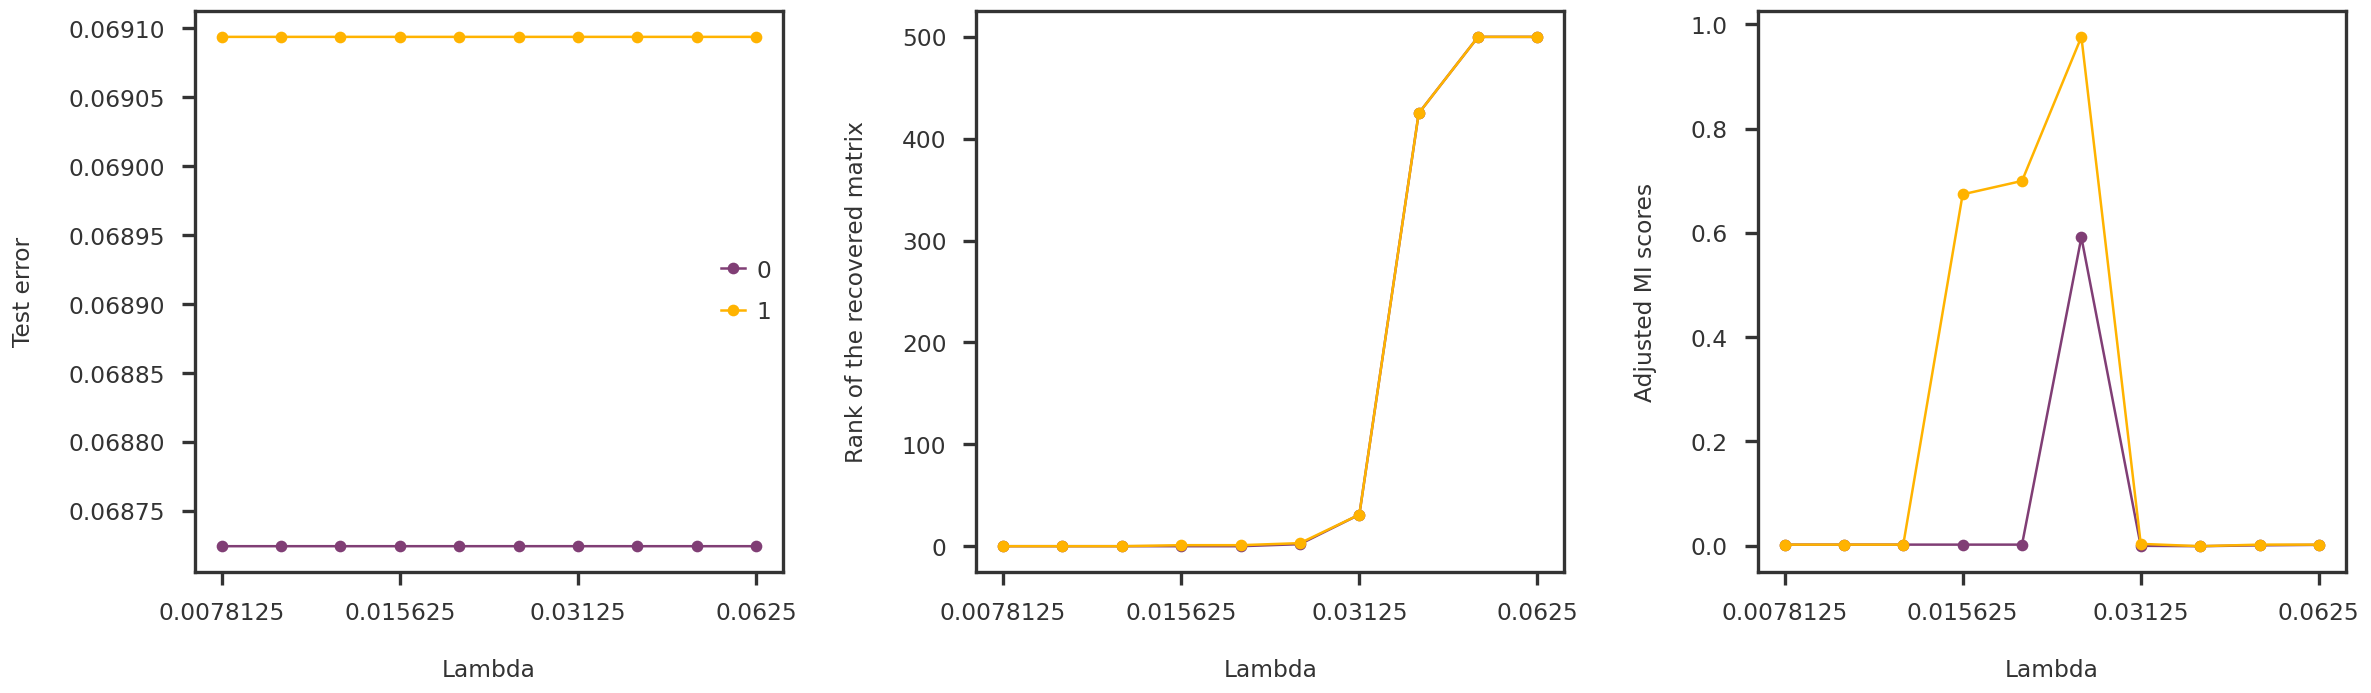

In [26]:
fig = plt.figure(figsize = (20, 6))
ax1 = fig.add_subplot(131)
for k in range(kfolds):
    ax1.plot(np.log2(lmb_values), [x[k] for x in train_errors_ytrue.values()], 'o-', label = k)
ax1.legend()
ax1.set_ylabel("Test error")
ax1.set_xlabel("Lambda")

ax2 = fig.add_subplot(132)
for k in range(kfolds):
    ax2.plot(np.log2(lmb_values), [x[k] for x in recovered_matrix_ranks.values()], 'o-')
ax2.set_ylabel("Rank of the recovered matrix")
ax2.set_xlabel("Lambda")

ax3 = fig.add_subplot(133)
for k in range(kfolds):
    ax3.plot(np.log2(lmb_values), [x[k] for x in adj_mi_scores.values()], 'o-')
ax3.set_ylabel("Adjusted MI scores")
ax3.set_xlabel("Lambda")

for ax in [ax1, ax2, ax3]:
    mpl_utils.set_xticks(ax, scale = 'log2', spacing = 'log2')

plt.tight_layout(w_pad = 2.0)
plt.show()

In [45]:
np.std(Y_cent, axis = 0)

array([0.79278496, 0.23689886, 1.42405339, 0.81935309, 0.23729693,
       0.09144476, 0.42372639, 2.6104184 , 0.74470766, 0.26436492,
       0.34641285, 0.51679419, 1.00400527, 0.23558578, 0.22506705,
       0.8008573 , 2.56458015, 1.13226585, 0.53951641, 2.29523606,
       1.20775272, 2.06884158, 0.23195788, 1.82242354, 2.61664765,
       0.11415811, 1.82049267, 1.27572457, 0.59081701, 0.2556268 ,
       0.59683477, 0.15716198, 1.90974463, 1.39929027, 0.21565277,
       1.56208744, 2.3567678 , 2.38656392, 1.29505895, 0.88790988,
       2.39916502, 1.29966879, 2.02256183, 1.08538357, 1.51615966,
       1.15170198, 0.91148067, 2.12905593, 0.11275457, 0.28150256,
       4.06321808, 0.21707237, 3.37273166, 1.43174134, 1.5379488 ,
       0.80468443, 0.69749435, 0.59450189, 0.14475763, 0.37834804,
       0.9781591 , 0.24520509, 1.70803553, 1.99788534, 1.26419147,
       0.79987723, 1.1692679 , 2.24607765, 0.8052394 , 2.13117163,
       2.29366181, 3.21508755, 1.51214671, 0.72536485, 2.75564

In [37]:
np.array(~(fold_labels == 1)).astype(int)

array([[0, 0, 1, ..., 0, 0, 1],
       [1, 1, 0, ..., 0, 0, 1],
       [1, 1, 1, ..., 0, 1, 0],
       ...,
       [0, 0, 0, ..., 1, 0, 1],
       [1, 0, 0, ..., 1, 1, 1],
       [1, 0, 1, ..., 1, 0, 0]])

In [32]:
nsnp * ngwas

500000

In [18]:
recovered_matrix_ranks

{0.0078125: [0, 0],
 0.009843133202303695: [0, 0],
 0.012401570718501561: [0, 0],
 0.015625: [0, 1],
 0.01968626640460739: [0, 1],
 0.024803141437003108: [2, 3],
 0.03125: [31, 31],
 0.03937253280921478: [425, 425],
 0.049606282874006216: [500, 500],
 0.0625: [500, 500]}

In [19]:
1. / np.sqrt(np.max(Y_cent.shape))

0.03162277660168379